# 2024: Reconocimiento de habla con Dynamic Time warping, dependiente de locutor, multilocutor e independiente del locutor: Segunda Parte

Reconocedor de habla  Nearest Neighbor implementado con  DTW + MFCC.

Práctica adaptada por J.M.Pardo

# Reconocimiento dependiente del locutor
Debemos grabar una base de datos y subirla al directorio /content/.
Para ello, grabaremos en nuestro ordenador las siguientes 9 palabras:
  
  bata, caca,  cara, cata, paca, pata, para, vaca, vara

La grabación de cada  palabra se hará al menos dos veces (mejor 4 o 6 ).
Inicialmente la prueba será con un solo locutor (dependiente del locutor) pero posteriormente (ver abajo) podremos elegir más de un locutor para cada palabra.

Una vez grabadas, debemos convertirlas a formato *.wav. Para el caso en el que no estén en ese formato  usar un convertidor en linea, por ejemplo https://online-audio-converter.com/es/

Hay seguir una nomenclatura determinada para cada grabación para no tener confusiones, por ejemplo paca_xxx_1.wav sería el nombre de la  primera grabación de la palabra "paca" por el locutor con iniciales "xxx" Iniciales con minúsculas.

Una vez tengamos las grabaciones separadas por palabras, haremos un .zip con todas ellas y crearemos un fichero comprimido llamado por ejemplo practica.zip

Muy importante es darnos cuenta de que los audios grabados tenemos que tenerlos siempre grabados y salvados en nuestro ordenador (en este caso nuestro google drive)  y subirlos a google-colab cuando vayamos a hacer la práctica, ya que una vez que nos hayamos desconectado del entorno de ejecución, todos los audios que hayamos subido desaparecerán.



In [ ]:
from google.colab import drive

# Montar Google Drive
drive.mount('/content/drive')
import zipfile
import os


Mounted at /content/drive






# Introducción

El reconocimiento **dependiente de locutor** implica que todas las grabaciones que hagamos corresponden a un solo locutor.

El reconocimiento **multilocutor** implica que todas las grabaciones que hagamos proceden de varios locutores pero tanto las grabaciones para entrenamiento (train) como las de  los tests de prueba (llamados aqui de validación) también contienen todos los locutores. Comparamos las grabaciones de validación con todos los locutores.

El reconocimiento **independiente del locutor** significa que las grabaciones de entrenamiento proceden de unos locutores (idealmente muchos) y las de validacion de otros (distintos a los anteriores)

In [ ]:
%matplotlib inline
# se establece una configuración especial para que las figuras de Matplotlib se muestren dentro del notebook

import glob
import librosa
import numpy as np
!pip install dtw # instalamos el programa de comparación y extracción del alineamiento
from dtw import dtw, accelerated_dtw

  Preparing metadata (setup.py) ... done
  Created wheel for dtw: filename=dtw-1.4.0-py3-none-any.whl size=5299 sha256=1e857dd4e9925244177bb775d7c7291da090701c700b7cce56ddf2e41f5053e7
  Stored in directory: /root/.cache/pip/wheels/71/31/62/5e67f6e31521b8cc1652aa58b1ed0c892514d01eeee85fd49c
Successfully built dtw


In [ ]:

# Obtener el directorio de trabajo actual

directorio_actual = os.getcwd()

# Imprimir el directorio actual

print("Directorio actual:", directorio_actual)

directorio = '/content/drive/MyDrive/Procesamiento del habla/Práctica 2 - DTW/' #cambiar el nombre del directorio al directorio personal

print("Directorio actual:", directorio)
# Listar archivos en el directorio
archivos = os.listdir(directorio)

# Imprimir la lista de archivos
print ("Archivos:")
for archivo in archivos:
    print(archivo)



Directorio actual: /content
Directorio actual: /content/drive/MyDrive/Procesamiento del habla/Práctica 2 - DTW/
Archivos:
practica_1.zip
practica_2.zip
2024-recortar grabacion de audio.ipynb
2024-DTW- grafico.ipynb
2024-DTW-segunda parte_v2.ipynb


In [ ]:
!unzip '/content/drive/MyDrive/Procesamiento del habla/Práctica 2 - DTW/practica_2.zip'  #ponga aqui el fichero .zip que contiene todos los audios

Archive:  /content/drive/MyDrive/Procesamiento del habla/Práctica 2 - DTW/practica_2.zip
   creating: bata/
  inflating: bata/bata_for_1.wav     
  inflating: __MACOSX/bata/._bata_for_1.wav  
  inflating: bata/bata_for_2.wav     
  inflating: __MACOSX/bata/._bata_for_2.wav  
   creating: caca/
  inflating: caca/caca_for_1.wav     
  inflating: __MACOSX/caca/._caca_for_1.wav  
  inflating: caca/caca_for_2.wav     
  inflating: __MACOSX/caca/._caca_for_2.wav  
   creating: cara/
  inflating: cara/cara_for_2.wav     
  inflating: __MACOSX/cara/._cara_for_2.wav  
  inflating: cara/cara_for_1.wav     
  inflating: __MACOSX/cara/._cara_for_1.wav  
   creating: cata/
  inflating: cata/cata_for_1.wav     
  inflating: __MACOSX/cata/._cata_for_1.wav  
  inflating: cata/cata_for_2.wav     
  inflating: __MACOSX/cata/._cata_for_2.wav  
   creating: paca/
  inflating: paca/paca_for_1.wav     
  inflating: __MACOSX/paca/._paca_for_1.wav  
  inflating: paca/paca_for_2.wav     
  inflating: __MACOSX/

In [ ]:
DATABASE_PATH = '/content/'

In [ ]:

labels = ["bata","caca","cara","cata","paca","para","pata","vaca","vara"]  # lista ordenada indexable


In [ ]:
# El valor de N es el número de grabaciones hechas y subidas por cada palabra
# si hemos hecho dos grabaciones, aqui pondremos 2 y si hemos hecho otro valor (par), pondremos ese valor
N = 2

## Precompute all MFCCs

La siguiente celda lo que hace es calcular los parámetros Mel Frequency Cepstrum de todos los ficheros subidos. Por defecto se calculan 20 coeficientes mfcc

In [ ]:
mfccs = [] # esta será una lista que contiene todas las grabaciones, una detrás de otra
true_labels = [] # esta serña una lista de las etiquetas "palabras" de cada una de las grabaciones

for l in labels:
  print (l)



for l in  range(9): # la variable l itera sobre las etiquetas listadas arriba
    str = labels[l]
    sound = glob.glob(os.path.join(DATABASE_PATH, str, '*.wav'))  # ojo, el orden que crea aqui NO es alfabético por lo que los ficheros 1,2 etc
                                                                    # no están siempre en el mismo orden por lo que lo ordenamos en la siguiente línea
    sounds= sorted(sound)
    sounds = sounds[:N] # toma los primeros N elementos de la lista de una palabra determinada
    print (sounds) # esto nos servirá para ver el orden final de los audios creados.

    for s in sounds:
        y, sr = librosa.load(s)
        mfcc = librosa.feature.mfcc(y=y,sr=sr) # calculo los coeficientes mfcc para una grabación cuya forma de audio temporal esta en el vector y
                              # mfcc será una matriz filas-columnas en la que cada fila es un coeficiente mfcc y cada columna es una ventana temporal
        mfccs.append(mfcc.T) # añado los valores mfcc de cada grabación a una lista global. Hago la matriz traspuesta para que todas las líneas
                              # contengan el mismo número de columnas (20 = n. coeficientes mfcc)
        true_labels.append(str)
        print(mfcc) #esto es para debugging


true_labels = np.array(true_labels)

print("True labels",true_labels)


bata
caca
cara
cata
paca
para
pata
vaca
vara
['/content/bata/bata_for_1.wav', '/content/bata/bata_for_2.wav']
[[-6.53671387e+02 -6.82734009e+02 -7.64798462e+02 ... -7.03642334e+02
  -6.31883179e+02 -6.22406189e+02]
 [ 1.08816071e+02  1.08406204e+02  4.78096924e+01 ...  1.00428146e+02
   1.39730530e+02  1.46352081e+02]
 [ 1.69831562e+01  3.44685745e+01  4.37412262e+01 ...  4.06069565e+01
   1.75567284e+01  1.48928051e+01]
 ...
 [ 7.19347906e+00  1.32398491e+01  6.10114193e+00 ...  2.22734547e+00
   6.50012636e+00  7.36688805e+00]
 [ 2.04189610e+00  6.65769958e+00  6.69841146e+00 ... -4.05037403e-01
  -5.73336983e+00 -7.62012291e+00]
 [-2.72182918e+00  2.67046690e+00  7.11677074e+00 ... -2.82544065e+00
  -9.94275284e+00 -1.10368090e+01]]
[[-7.2167236e+02 -7.3589227e+02 -7.6457422e+02 ... -6.1573236e+02
  -6.3283368e+02 -6.5808197e+02]
 [ 8.1054840e+01  7.1974098e+01  4.4564522e+01 ...  1.5393774e+02
   1.4860107e+02  1.3239088e+02]
 [ 3.7753571e+01  4.5167992e+01  4.1586975e+01 ...  1.63

Fijémonos en el listado que aparece después de ejecutar la celda anterior.

En mi ejemplo son:
['/content/bata/bata_jmp_1.wav', '/content/bata/bata_jmp_2.wav']
['/content/caca/caca_jmp_2.wav', '/content/caca/caca_jmp_1.wav']
['/content/cara/cara_jmp_1.wav', '/content/cara/cara_jmp_2.wav']
['/content/cata/cata_jmp_2.wav', '/content/cata/cata_jmp_1.wav']
['/content/paca/paca_jmp_2.wav', '/content/paca/paca_jmp_1.wav']
['/content/para/para_jmp_2.wav', '/content/para/para_jmp_1.wav']
['/content/pata/pata_jmp_2.wav', '/content/pata/pata_jmp_1.wav']
['/content/vaca/vaca_jmp_1.wav', '/content/vaca/vaca_jmp_2.wav']
['/content/vara/vara_jmp_1.wav', '/content/vara/vara_jmp_2.wav']

Por un lado nos aparece los nombres de los ficheros de audio y finalmente nos aparecen las etiquetas de cada palabra pronunciada.

En mi ejemplo son:

['bata' 'bata' 'caca' 'caca' 'cara' 'cara' 'cata' 'cata' 'paca' 'paca'
 'para' 'para' 'pata' 'pata' 'vaca' 'vaca' 'vara' 'vara']

 El orden de estas etiquetas desde 0 a 17 (para el caso de dos grabaciones por palabra) nos va a marcar la etiqueta de la palabra que se ha pronuciado.

Por ejemplo,  la primera etiqueta es 'bata', el indice 0 (que luego usaremos) se refiere a la palabra pronunciada 'bata' y al fichero correspondiente bata_jmp_1.wav que tenemos en primer lugar . La segunda es 'bata' se refiere al índice 1 y al segundo fichero bata_jmp_2.wav que nos aparece en el listado en segunda posición. La  tercera es 'vara' esto se corresponderá al indice 2 y al fichero vara_jmp_1.wav. Si hubiéramos grabado 4 audios por palabra, las primeras 4 etiquetas corresponderían a la primera palabra y los índices serían 0,1,2,3 y los audios correspondientes serían los que aparecerían en los listados.

Es muy importante que asociemos los índices a los ficheros de audio, pues despues tendremos que elegir unos para validacion (test) y otros para entrenamiento (train)

## Prepare train/val dataset

 En este momento, es importante crear los valores de los arrays de I_val e I_train
estos arrays contienen los índices de las palabras a reconocer (I_val) y las palabras grabadas (I_train)
 para asignarlos, debemos fijarnos en la salida de la celda anterior, donde aparecen en orden los audios de cada palabra
 en este ejemplo particular, tenemos dos grabaciones por palabra, y hemos asignado la primera grabación (indices pares)
a la validación (test) y la segunda (índices impares) a la grabación de entrenamiento. En el caso de que hubieramos grabado , por ejemplo, 4 audios por palabra
los valores serían por ejemplo I_val=[0,1,4,5,8,9....] e I_train=[2,3,6,7,10,11,...] donde hemos elegido las dos primeras
a la validación y las dos segundas a la grabación de entrenamiento

I_val= [0,2,4,6,8,10,12,14,16]
I_train= [1,3,5,7,9,11,13,15,17]
I_val= [0,2,4,6,8,10,12,14,16] # estos índices corresponden a la primera grabación de cada palabra por ejemplo
I_train= [1,3,5,7,9,11,13,15,17] # estos índices corresponden a la segunda grabación de cada palabra por ejemplo

In [ ]:
# Los índicces I_val e I_train puede generarlos a mano como le ponemos abajo
I_val= [0,2,4,6,8,10,12,14,16] # estos índices corresponden a la primera grabación de cada palabra por ejemplo
I_train= [1,3,5,7,9,11,13,15,17] # estos índices corresponden a la segunda grabación de cada palabra por ejemplo


# O bien, le añadimos aquí una manera de generar estos índices concretos
I_val =[]
I_train = []

for i in range(9):
  I_val.append(i*2)
  I_train.append(i*2+1)

print (I_val, I_train)

[0, 2, 4, 6, 8, 10, 12, 14, 16] [1, 3, 5, 7, 9, 11, 13, 15, 17]


## Cross Validation

La siguiente celda, simplemente define la función que se va a ejecutar.
La función dtw es la que realiza el alineamiento dinámico temporal y la función
cross_validation devuelve las palabras pronunciadas y reconocidas y la tasa de acierto

In [ ]:
def cross_validation_abs(train_indices, val_indices):
    score = 0.0

    for i in val_indices:
        x = mfccs[i]


        dmin, jmin = np.inf, -1
        for j in train_indices:
            y = mfccs[j]
            d, _, _, _ = dtw(x, y, dist=lambda x, y: np.linalg.norm(x - y, ord=1)) # distancia absoluta

            if d < dmin:
                dmin = d
                jmin = j

        score += 1.0 if (true_labels[i] == true_labels[jmin]) else 0.0
        actual.append(true_labels[i])
        predicted.append (true_labels[jmin])
        print ("pronunciada =", true_labels[i], "     reconocida =",true_labels[jmin] )

    return score / len(val_indices)

In [ ]:
def cross_validation_cos(train_indices, val_indices):
    score = 0.0

    for i in val_indices:
        x = mfccs[i]


        dmin, jmin = np.inf, -1
        for j in train_indices:
            y = mfccs[j]
            d, _, _, _ = accelerated_dtw(x, y, 'cosine') # distancia coseno

            if d < dmin:
                dmin = d
                jmin = j

        score += 1.0 if (true_labels[i] == true_labels[jmin]) else 0.0
        actual.append(true_labels[i])
        predicted.append (true_labels[jmin])
        print ("pronunciada =", true_labels[i], "     reconocida =",true_labels[jmin] )

    return score / len(val_indices)

Ejecute la celda de abajo para obtener la tasa de reconocimiento y los valores pronunciados y reconocidos. Descomente la línea con la funcion accelerated_dtw y comente la dtw y obtenga el mismo resultado pero ahora con la distancia coseno.

In [ ]:
# realiza el reconocimiento de las palabras que están en el grupo de validación
#frente a las que están en el grupo de train

actual =[]
predicted =[]

rec_rate = cross_validation_abs(I_train, I_val)
print('Recognition rate {}%'.format(100. * rec_rate))
print (actual)
print (predicted)

pronunciada = bata      reconocida = bata
pronunciada = caca      reconocida = cara
pronunciada = cara      reconocida = cara
pronunciada = cata      reconocida = cara
pronunciada = paca      reconocida = vaca
pronunciada = para      reconocida = paca
pronunciada = pata      reconocida = pata
pronunciada = vaca      reconocida = vaca
pronunciada = vara      reconocida = vaca
Recognition rate 44.44444444444444%
['bata', 'caca', 'cara', 'cata', 'paca', 'para', 'pata', 'vaca', 'vara']
['bata', 'cara', 'cara', 'cara', 'vaca', 'paca', 'pata', 'vaca', 'vaca']


In [ ]:
# realiza el reconocimiento de las palabras que están en el grupo de validación
#frente a las que están en el grupo de train

actual =[]
predicted =[]

rec_rate = cross_validation_cos(I_train, I_val)
print('Recognition rate {}%'.format(100. * rec_rate))
print (actual)
print (predicted)

pronunciada = bata      reconocida = bata
pronunciada = caca      reconocida = caca
pronunciada = cara      reconocida = cara
pronunciada = cata      reconocida = cara
pronunciada = paca      reconocida = pata
pronunciada = para      reconocida = para
pronunciada = pata      reconocida = pata
pronunciada = vaca      reconocida = vaca
pronunciada = vara      reconocida = vara
Recognition rate 77.77777777777779%
['bata', 'caca', 'cara', 'cata', 'paca', 'para', 'pata', 'vaca', 'vara']
['bata', 'caca', 'cara', 'cara', 'pata', 'para', 'pata', 'vaca', 'vara']


Los resultados obtenidos muestran la correspondencia entre las palabras pronunciadas y las palabras reconocidas durante el proceso de *cross validation* definido en las funciones.

Para la distancia absoluta podemos decir lo siguiente:

* **Pronunciada vs. reconocida**: En cada línea impresa, se muestra la palabra pronunciada y la palabra reconocida. Por ejemplo, en la primera línea, la palabra pronunciada es "bata" y la palabra reconocida también es "bata". En unas ocasiones, las palabras pronunciadas y reconocidas coinciden, mientras que en otras no.

* **Tasa de reconocimiento:** La tasa de reconocimiento se calcula al dividir el puntaje acumulado por el número total de muestras de validación (len(val_indices)). En este caso, la tasa de reconocimiento es del 44,44%, lo que indica que aproximadamente el 44,44% de las palabras pronunciadas fueron correctamente reconocidas por el sistema.

* **Listas de etiquetas reales y predichas:** Las listas *actual* y *predicted* contienen las etiquetas reales y predichas, respectivamente, para todas las muestras de validación. Estas listas pueden ser útiles para un análisis más detallado de los errores de reconocimiento y la calidad general del sistema.

Para la distancia coseno podemos decir lo siguiente:

* **Pronunciada vs. reconocida:** Se observa que en la mayoría de los casos, la palabra pronunciada y la palabra reconocida coinciden.
Por ejemplo, en la primera línea, la palabra pronunciada es "bata" y la palabra reconocida también es "bata". Este conjunto de resultados muestra una correspondencia más precisa entre las palabras pronunciadas y reconocidas en comparación con el conjunto anterior de resultados.

* **Tasa de reconocimiento:** En este caso, la tasa de reconocimiento es del 77.78%, lo que indica que aproximadamente el 77.78% de las palabras pronunciadas fueron correctamente reconocidas por el sistema. Esta tasa de reconocimiento es más alta que la del conjunto anterior de resultados, lo que sugiere una mejora en la precisión del sistema de reconocimiento de palabras.

# Segunda tarea

Modifique las celdas anteriores y prográmelas para obtener también la distancia de reconocimiento en cada prueba.

Haga un comentario sobre el valor de las distancias obtenidas.

In [ ]:
def cross_validation_abs(train_indices, val_indices):
    score = 0.0
    recognition_distances = []

    for i in val_indices:
        x = mfccs[i]
        dmin, jmin = np.inf, -1

        for j in train_indices:
            y = mfccs[j]
            d, _, _, _ = dtw(x, y, dist=lambda x, y: np.linalg.norm(x - y, ord=1)) # Distancia absoluta

            if d < dmin:
                dmin = d
                jmin = j

        score += 1.0 if (true_labels[i] == true_labels[jmin]) else 0.0
        recognition_distances.append(dmin)  # Guarda la distancia de reconocimiento
        actual.append(true_labels[i])
        predicted.append(true_labels[jmin])
        print("Pronunciada =", true_labels[i], "     Reconocida =", true_labels[jmin], "     Distancia absoluta=", dmin)

    recognition_rate = score / len(val_indices)
    average_recognition_distance = sum(recognition_distances) / len(recognition_distances)  # Calcula la distancia media reconocida
    return recognition_rate, recognition_distances, average_recognition_distance

actual = []
predicted = []

rec_rate, recognition_distances, average_recognition_distance = cross_validation_abs(I_train, I_val)
print('Recognition rate: {}%'.format(100. * rec_rate))
print('Distancias de reconocimiento:', recognition_distances)
print('Distancia absoluta media reconocida:', average_recognition_distance)
print('Etiquetas reales:', actual)
print('Etiquetas predichas:', predicted)

Pronunciada = bata      Reconocida = bata      Distancia absoluta= 16861.20154762268
Pronunciada = caca      Reconocida = cara      Distancia absoluta= 15436.511703491211
Pronunciada = cara      Reconocida = cara      Distancia absoluta= 13474.601305007935
Pronunciada = cata      Reconocida = cara      Distancia absoluta= 13815.592716217041
Pronunciada = paca      Reconocida = vaca      Distancia absoluta= 16519.0558013916
Pronunciada = para      Reconocida = paca      Distancia absoluta= 14727.422264099121
Pronunciada = pata      Reconocida = pata      Distancia absoluta= 20551.154594421387
Pronunciada = vaca      Reconocida = vaca      Distancia absoluta= 12833.989437103271
Pronunciada = vara      Reconocida = vaca      Distancia absoluta= 13008.745727539062
Recognition rate: 44.44444444444444%
Distancias de reconocimiento: [16861.20154762268, 15436.511703491211, 13474.601305007935, 13815.592716217041, 16519.0558013916, 14727.422264099121, 20551.154594421387, 12833.989437103271, 1300

In [ ]:
def cross_validation_cos(train_indices, val_indices):
    score = 0.0
    recognition_distances = []

    for i in val_indices:
        x = mfccs[i]
        dmin, jmin = np.inf, -1

        for j in train_indices:
            y = mfccs[j]
            d, _, _, _ = accelerated_dtw(x, y, 'cosine') # Distancia coseno

            if d < dmin:
                dmin = d
                jmin = j

        score += 1.0 if (true_labels[i] == true_labels[jmin]) else 0.0
        recognition_distances.append(dmin)  # Guarda la distancia de reconocimiento
        actual.append(true_labels[i])
        predicted.append(true_labels[jmin])
        print("Pronunciada =", true_labels[i], "     Reconocida =", true_labels[jmin], "     Distancia coseno=", dmin)

    recognition_rate = score / len(val_indices)
    average_recognition_distance = sum(recognition_distances) / len(recognition_distances)  # Calcula la distancia media reconocida
    return recognition_rate, recognition_distances, average_recognition_distance

actual = []
predicted = []

rec_rate, recognition_distances, average_recognition_distance = cross_validation_cos(I_train, I_val)
print('Recognition rate: {}%'.format(100. * rec_rate))
print('Distancias de reconocimiento:', recognition_distances)
print('Distancia coseno media reconocida:', average_recognition_distance)
print('Etiquetas reales:', actual)
print('Etiquetas predichas:', predicted)

Pronunciada = bata      Reconocida = bata      Distancia coseno= 0.19392046789944783
Pronunciada = caca      Reconocida = caca      Distancia coseno= 0.18463768557376348
Pronunciada = cara      Reconocida = cara      Distancia coseno= 0.19313270956545758
Pronunciada = cata      Reconocida = cara      Distancia coseno= 0.19898358125471438
Pronunciada = paca      Reconocida = pata      Distancia coseno= 0.263479701819606
Pronunciada = para      Reconocida = para      Distancia coseno= 0.1793646377463416
Pronunciada = pata      Reconocida = pata      Distancia coseno= 0.28802738607448597
Pronunciada = vaca      Reconocida = vaca      Distancia coseno= 0.15824251469534334
Pronunciada = vara      Reconocida = vara      Distancia coseno= 0.20368850400727534
Recognition rate: 77.77777777777779%
Distancias de reconocimiento: [0.19392046789944783, 0.18463768557376348, 0.19313270956545758, 0.19898358125471438, 0.263479701819606, 0.1793646377463416, 0.28802738607448597, 0.15824251469534334, 0.203

1. **Función con distancia absoluta:**

* **Tasa de reconocimiento:** La tasa de reconocimiento es del 44.44%, lo que indica que aproximadamente el 44.44% de las palabras pronunciadas fueron correctamente reconocidas por el sistema.
* **Distancias de reconocimiento:** Las distancias de reconocimiento varían para cada par de palabras pronunciadas y reconocidas. La distancia media reconocida es de aproximadamente 15247.59 unidades.
* **Observaciones:** Algunas palabras como "cara" y "vaca" son reconocidas correctamente. Sin embargo, otras palabras como "cata", "paca" y "vara" son reconocidas incorrectamente. La distancia media reconocida indica que el sistema tiende a tener dificultades para reconocer algunas palabras, ya que las distancias son relativamente altas.

2. **Función con distancia coseno:**

* **Tasa de reconocimiento:** La tasa de reconocimiento es del 77.78%, lo que indica que aproximadamente el 77.78% de las palabras pronunciadas fueron correctamente reconocidas por el sistema.
* **Distancias de reconocimiento:** Las distancias de reconocimiento son valores entre 0 y 1 que representan la similitud entre los vectores. La distancia media reconocida es de aproximadamente 0.207.
* **Observaciones:** La mayoría de las palabras son reconocidas correctamente con una distancia coseno baja. La distancia media reconocida indica que el sistema tiende a reconocer las palabras con mayor precisión utilizando la distancia coseno en comparación con la distancia absoluta.

# Tercera Tarea
Una vez ejecutada la celda anterior, anotar la tasa de reconocimiento obtenida y crear la matriz de confusión que tendra una dimension de 9*9 celdas en la que veamos en el eje vertical las palabras pronunciadas y en el eje horizontal las reconocidas por cada una de las pronunciadas. Esto podremos hacerlo anotandolo a mano a partir del resultado obtenido de la ejecución de la celda anterior o bien haciendo un programa que lo haga. Será del estilo del dibujo de abajo.

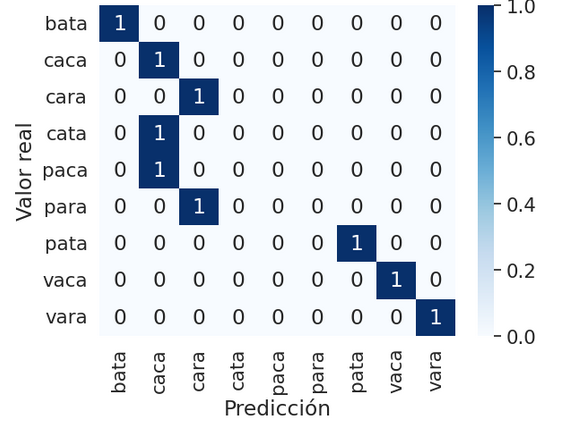

Una opción para hacerlo programado es usar las librerías seaborn y matplotlib

In [ ]:
pip install seaborn matplotlib

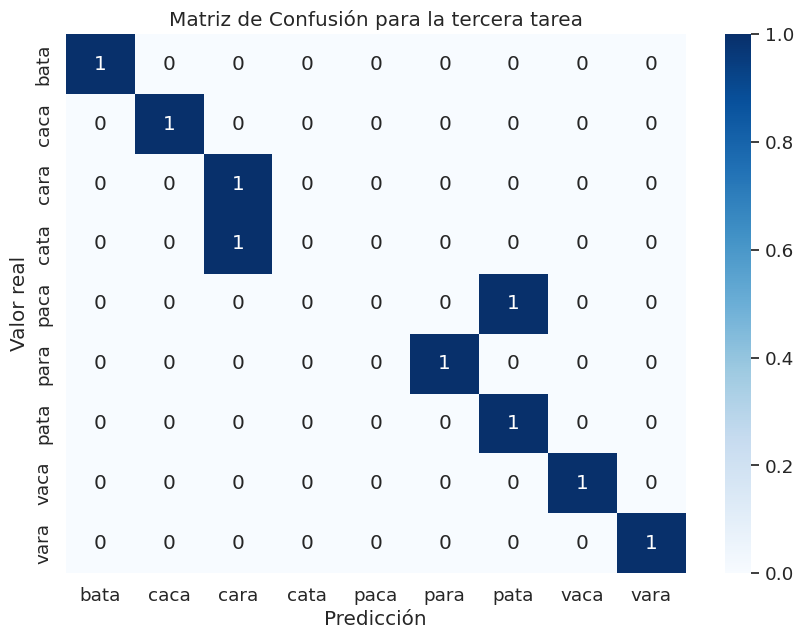

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calculamos la matriz de confusión
conf_matrix = confusion_matrix(actual, predicted, labels=labels)

# Creamos la matriz de confusión
plt.figure(figsize=(10, 7))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicción')
plt.ylabel('Valor real')
plt.title('Matriz de Confusión para la tercera tarea')
plt.show()

# Cuarta tarea

Con el otro script adjunto recorte la parte del silencio de los audios, grabe los audios recortados en google drive. Cree un nuevo .zip y a partir de ahi vuelva a ejecutar el script anterior

In [25]:
!unzip '/content/drive/MyDrive/Procesamiento del habla/Práctica 2 - DTW/audios_recortados.zip'  #ponga aqui el fichero .zip que contiene todos los audios

Archive:  /content/drive/MyDrive/Procesamiento del habla/Práctica 2 - DTW/audios_recortados.zip
replace para/para_for_1.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: para/para_for_1.wav     
replace bata/bata_for_2.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: bata/bata_for_2.wav     
replace paca/paca_for_2.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: paca/paca_for_2.wav     
replace vaca/vaca_for_1.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: vaca/vaca_for_1.wav     
replace paca/paca_for_1.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: paca/paca_for_1.wav     
replace cata/cata_for_2.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: cata/cata_for_2.wav     
replace cara/cara_for_2.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: cara/cara_for_2.wav     
replace caca/caca_for_1.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: caca/caca_for_1.wav     
replace caca/caca_for_2.wav? [y]es, [n]o, [A]ll,

In [26]:
DATABASE_PATH = '/content/audios_recortados/'

In [27]:

labels = ["bata","caca","cara","cata","paca","para","pata","vaca","vara"]  # lista ordenada indexable


In [28]:
# El valor de N es el número de grabaciones hechas y subidas por cada palabra
# si hemos hecho dos grabaciones, aqui pondremos 2 y si hemos hecho otro valor (par), pondremos ese valor
N = 2

In [29]:
mfccs = [] # esta será una lista que contiene todas las grabaciones, una detrás de otra
true_labels = [] # esta serña una lista de las etiquetas "palabras" de cada una de las grabaciones

for l in labels:
  print (l)



for l in  range(9): # la variable l itera sobre las etiquetas listadas arriba
    str = labels[l]
    sound = glob.glob(os.path.join(DATABASE_PATH, str, '*.wav'))  # ojo, el orden que crea aqui NO es alfabético por lo que los ficheros 1,2 etc
                                                                    # no están siempre en el mismo orden por lo que lo ordenamos en la siguiente línea
    sounds= sorted(sound)
    sounds = sounds[:N] # toma los primeros N elementos de la lista de una palabra determinada
    print (sounds) # esto nos servirá para ver el orden final de los audios creados.

    for s in sounds:
        y, sr = librosa.load(s)
        mfcc = librosa.feature.mfcc(y=y,sr=sr) # calculo los coeficientes mfcc para una grabación cuya forma de audio temporal esta en el vector y
                              # mfcc será una matriz filas-columnas en la que cada fila es un coeficiente mfcc y cada columna es una ventana temporal
        mfccs.append(mfcc.T) # añado los valores mfcc de cada grabación a una lista global. Hago la matriz traspuesta para que todas las líneas
                              # contengan el mismo número de columnas (20 = n. coeficientes mfcc)
        true_labels.append(str)
        print(mfcc) #esto es para debugging


true_labels = np.array(true_labels)

print("True labels",true_labels)


bata
caca
cara
cata
paca
para
pata
vaca
vara
['/content/audios_recortados/bata/bata_for_1.wav', '/content/audios_recortados/bata/bata_for_2.wav']
[[-5.50512817e+02 -5.23680359e+02 -5.42770325e+02 -5.61524780e+02
  -4.09234558e+02 -2.60676849e+02 -2.24613953e+02 -2.30353058e+02
  -2.54158600e+02 -2.84938812e+02 -3.42957153e+02 -3.82586060e+02
  -3.30650696e+02 -3.30843964e+02 -3.75381775e+02 -4.20485626e+02
  -4.62565216e+02]
 [ 1.66279694e+02  1.79243713e+02  1.76461304e+02  1.73602966e+02
   1.60739532e+02  1.63061935e+02  1.58175369e+02  1.44551437e+02
   1.44158722e+02  1.54365997e+02  1.54839417e+02  1.42035126e+02
   1.55681458e+02  1.76885376e+02  1.88484283e+02  1.74911301e+02
   1.49719849e+02]
 [ 2.54688053e+01  1.76876488e+01  2.17315140e+01  2.87405663e+01
   2.64637399e+00 -2.52676830e+01 -4.62580109e+01 -7.12583008e+01
  -7.08455048e+01 -4.90260849e+01 -1.83493156e+01  4.72558641e+00
  -6.03118801e+00 -2.81536522e+01 -3.20800781e+01 -5.25758648e+00
   8.86185741e+00]
 [ 4.

In [30]:
# Los índicces I_val e I_train puede generarlos a mano como le ponemos abajo
I_val= [0,2,4,6,8,10,12,14,16] # estos índices corresponden a la primera grabación de cada palabra por ejemplo
I_train= [1,3,5,7,9,11,13,15,17] # estos índices corresponden a la segunda grabación de cada palabra por ejemplo


# O bien, le añadimos aquí una manera de generar estos índices concretos
I_val =[]
I_train = []

for i in range(9):
  I_val.append(i*2)
  I_train.append(i*2+1)

print (I_val, I_train)

[0, 2, 4, 6, 8, 10, 12, 14, 16] [1, 3, 5, 7, 9, 11, 13, 15, 17]


In [35]:
def cross_validation_abs(train_indices, val_indices):
    score = 0.0
    recognition_distances = []

    for i in val_indices:
        x = mfccs[i]
        dmin, jmin = np.inf, -1

        for j in train_indices:
            y = mfccs[j]
            d, _, _, _ = dtw(x, y, dist=lambda x, y: np.linalg.norm(x - y, ord=1)) # Distancia absoluta

            if d < dmin:
                dmin = d
                jmin = j

        score += 1.0 if (true_labels[i] == true_labels[jmin]) else 0.0
        recognition_distances.append(dmin)  # Guarda la distancia de reconocimiento
        actual.append(true_labels[i])
        predicted.append(true_labels[jmin])
        print("Pronunciada =", true_labels[i], "     Reconocida =", true_labels[jmin], "     Distancia absoluta=", dmin)

    recognition_rate = score / len(val_indices)
    average_recognition_distance = sum(recognition_distances) / len(recognition_distances)  # Calcula la distancia media reconocida
    return recognition_rate, recognition_distances, average_recognition_distance

actual = []
predicted = []

rec_rate, recognition_distances, average_recognition_distance = cross_validation_abs(I_train, I_val)
print('Recognition rate: {}%'.format(100. * rec_rate))
print('Distancias de reconocimiento:', recognition_distances)
print('Distancia absoluta media reconocida:', average_recognition_distance)
print('Etiquetas reales:', actual)
print('Etiquetas predichas:', predicted)

Pronunciada = bata      Reconocida = bata      Distancia absoluta= 3087.0193481445312
Pronunciada = caca      Reconocida = caca      Distancia absoluta= 1502.0438690185547
Pronunciada = cara      Reconocida = cara      Distancia absoluta= 2090.6443786621094
Pronunciada = cata      Reconocida = cara      Distancia absoluta= 2541.178253173828
Pronunciada = paca      Reconocida = paca      Distancia absoluta= 2826.7870178222656
Pronunciada = para      Reconocida = para      Distancia absoluta= 2094.714988708496
Pronunciada = pata      Reconocida = pata      Distancia absoluta= 2748.0945587158203
Pronunciada = vaca      Reconocida = vaca      Distancia absoluta= 2860.5431900024414
Pronunciada = vara      Reconocida = vara      Distancia absoluta= 2786.3813247680664
Recognition rate: 88.88888888888889%
Distancias de reconocimiento: [3087.0193481445312, 1502.0438690185547, 2090.6443786621094, 2541.178253173828, 2826.7870178222656, 2094.714988708496, 2748.0945587158203, 2860.5431900024414, 27

In [36]:
def cross_validation_cos(train_indices, val_indices):
    score = 0.0
    recognition_distances = []

    for i in val_indices:
        x = mfccs[i]
        dmin, jmin = np.inf, -1

        for j in train_indices:
            y = mfccs[j]
            d, _, _, _ = accelerated_dtw(x, y, 'cosine') # Distancia coseno

            if d < dmin:
                dmin = d
                jmin = j

        score += 1.0 if (true_labels[i] == true_labels[jmin]) else 0.0
        recognition_distances.append(dmin)  # Guarda la distancia de reconocimiento
        actual.append(true_labels[i])
        predicted.append(true_labels[jmin])
        print("Pronunciada =", true_labels[i], "     Reconocida =", true_labels[jmin], "     Distancia coseno=", dmin)

    recognition_rate = score / len(val_indices)
    average_recognition_distance = sum(recognition_distances) / len(recognition_distances)  # Calcula la distancia media reconocida
    return recognition_rate, recognition_distances, average_recognition_distance

actual = []
predicted = []

rec_rate, recognition_distances, average_recognition_distance = cross_validation_cos(I_train, I_val)
print('Recognition rate: {}%'.format(100. * rec_rate))
print('Distancias de reconocimiento:', recognition_distances)
print('Distancia coseno media reconocida:', average_recognition_distance)
print('Etiquetas reales:', actual)
print('Etiquetas predichas:', predicted)

Pronunciada = bata      Reconocida = bata      Distancia coseno= 0.10013227196425878
Pronunciada = caca      Reconocida = caca      Distancia coseno= 0.04281981878723229
Pronunciada = cara      Reconocida = cara      Distancia coseno= 0.09097950441849445
Pronunciada = cata      Reconocida = cata      Distancia coseno= 0.10112375966814802
Pronunciada = paca      Reconocida = paca      Distancia coseno= 0.12370603667244362
Pronunciada = para      Reconocida = para      Distancia coseno= 0.07363384273930906
Pronunciada = pata      Reconocida = pata      Distancia coseno= 0.13195856732030453
Pronunciada = vaca      Reconocida = vaca      Distancia coseno= 0.08563438376405319
Pronunciada = vara      Reconocida = vara      Distancia coseno= 0.09779971056480163
Recognition rate: 100.0%
Distancias de reconocimiento: [0.10013227196425878, 0.04281981878723229, 0.09097950441849445, 0.10112375966814802, 0.12370603667244362, 0.07363384273930906, 0.13195856732030453, 0.08563438376405319, 0.097799710

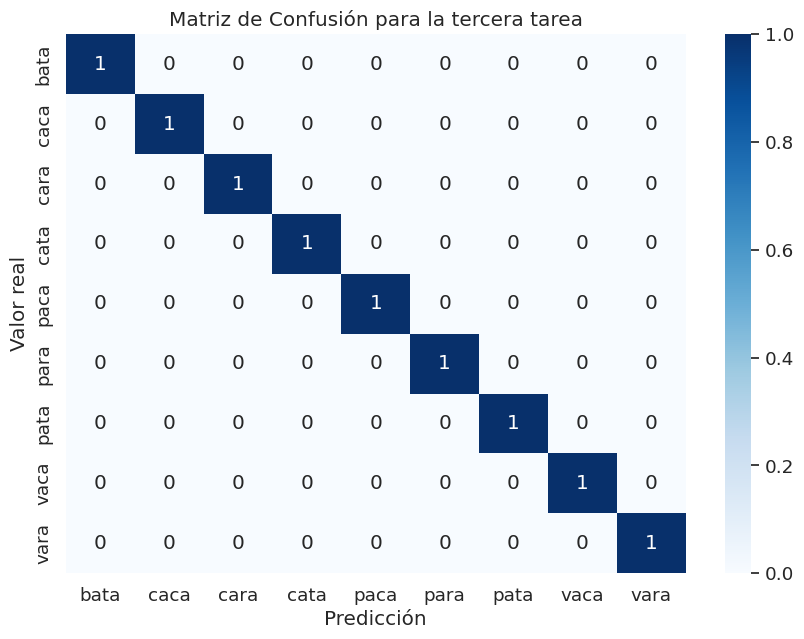

In [37]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calculamos la matriz de confusión
conf_matrix = confusion_matrix(actual, predicted, labels=labels)

# Creamos la matriz de confusión
plt.figure(figsize=(10, 7))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicción')
plt.ylabel('Valor real')
plt.title('Matriz de Confusión para la cuarta tarea')
plt.show()

# Quinta tarea opcional
Opcionalmente, grabar más ejemplos de las palabras pronunciadas por mas de un locutor (por ejemplo usando las grabaciones de algún compañero) y rehacer el experimento. Es importante observar un control manual de qué indice de fichero de audio corresponde a qué locutor.

Aquí tendremos dos opciones:


1.   Reconocimiento multilocutor:  Tanto en la lista de validación (test) como la de entrenamiento (train) hay grabaciones de ambos locutores. Por ejemplo debería haber al menos dos grabaciones de palabras por cada locutor para que una sirviera para I_train y la otra para I_val.

2.   Reconocimiento independiente de locutor:  en la lista de  validacion hay un locutor y en entrenamiento otro diferente. Debemos controlar  las listas I_val e I_train adecuadas con los índices que correspondan

Abajo le damos algunas pistas de cómo generar listas para esos problemas


In [49]:
!unzip '/content/drive/MyDrive/Procesamiento del habla/Práctica 2 - DTW/audios_multilocutor.zip' # cambiar el nombre del fichero .zip donde tenga sus grabaciones en su caso
# al descomprimir, se crean subdirectorios con los nombres de cada palabra y las grabaciones de las mismas en dichos directorios

Archive:  /content/drive/MyDrive/Procesamiento del habla/Práctica 2 - DTW/audios_multilocutor.zip
  inflating: audios_multilocutor/paca_for_1.wav  
replace __MACOSX/audios_multilocutor/._paca_for_1.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: __MACOSX/audios_multilocutor/._paca_for_1.wav  
  inflating: audios_multilocutor/pata_gga_2.wav  
  inflating: __MACOSX/audios_multilocutor/._pata_gga_2.wav  
  inflating: audios_multilocutor/cara_for_2.wav  
  inflating: __MACOSX/audios_multilocutor/._cara_for_2.wav  
  inflating: audios_multilocutor/paca_for_2.wav  
  inflating: __MACOSX/audios_multilocutor/._paca_for_2.wav  
  inflating: audios_multilocutor/cara_for_1.wav  
  inflating: __MACOSX/audios_multilocutor/._cara_for_1.wav  
  inflating: audios_multilocutor/pata_gga_1.wav  
  inflating: __MACOSX/audios_multilocutor/._pata_gga_1.wav  
  inflating: audios_multilocutor/vaca_for_1.wav  
  inflating: __MACOSX/audios_multilocutor/._vaca_for_1.wav  
  inflating: audios_multilocut

In [50]:
labels = ["bata","caca","cara","cata","paca","para","pata","vaca","vara"]  # lista ordenada indexable

In [55]:
DATABASE_PATH = "/content/audios_multilocutor/"

In [56]:
# El valor de N es el número de grabaciones hechas y subidas por cada palabra
# si hemos hecho dos grabaciones, aqui pondremos 2 y si hemos hecho otro valor (par), pondremos ese valor. Yo he puesto 12 por tener 12 grabaciones por palabra
N = 4

PRECOMPUTE MFCC

In [57]:
mfccs = [] # esta será una lista que contiene todas las grabaciones, una detrás de otra
true_labels = [] # esta serña una lista de las etiquetas "palabras" de cada una de las grabaciones

for l in labels:
  print (l)



for l in  range(9): # la variable l itera sobre las etiquetas listadas arriba
    str = labels[l]
    sound = glob.glob(os.path.join(DATABASE_PATH, str, '*.wav'))  # ojo, el orden que crea aqui NO es alfabético por lo que los ficheros 1,2 etc
                                                                    # no están siempre en el mismo orden por lo que lo ordenamos en la siguiente línea
    sounds= sorted(sound)
    sounds = sounds[:N] # toma los primeros N elementos de la lista de una palabra determinada
    print (sounds) # esto nos servirá para ver el orden final de los audios creados.

    for s in sounds:
        y, sr = librosa.load(s)
        mfcc = librosa.feature.mfcc(y=y,sr=sr) # calculo los coeficientes mfcc para una grabación cuya forma de audio temporal esta en el vector y
                              # mfcc será una matriz filas-columnas en la que cada fila es un coeficiente mfcc y cada columna es una ventana temporal
        mfccs.append(mfcc.T) # añado los valores mfcc de cada grabación a una lista global. Hago la matriz traspuesta para que todas las líneas
                              # contengan el mismo número de columnas (20 = n. coeficientes mfcc)
        true_labels.append(str)
        print(mfcc) #esto es para debugging


true_labels = np.array(true_labels)

print("True labels",true_labels)


bata
caca
cara
cata
paca
para
pata
vaca
vara
['/content/audios_multilocutor/bata/bata_for_1.wav', '/content/audios_multilocutor/bata/bata_for_2.wav', '/content/audios_multilocutor/bata/bata_gga_1.wav', '/content/audios_multilocutor/bata/bata_gga_2.wav']
[[-5.50512817e+02 -5.23680359e+02 -5.42770325e+02 -5.61524780e+02
  -4.09234558e+02 -2.60676849e+02 -2.24613953e+02 -2.30353058e+02
  -2.54158600e+02 -2.84938812e+02 -3.42957153e+02 -3.82586060e+02
  -3.30650696e+02 -3.30843964e+02 -3.75381775e+02 -4.20485626e+02
  -4.62565216e+02]
 [ 1.66279694e+02  1.79243713e+02  1.76461304e+02  1.73602966e+02
   1.60739532e+02  1.63061935e+02  1.58175369e+02  1.44551437e+02
   1.44158722e+02  1.54365997e+02  1.54839417e+02  1.42035126e+02
   1.55681458e+02  1.76885376e+02  1.88484283e+02  1.74911301e+02
   1.49719849e+02]
 [ 2.54688053e+01  1.76876488e+01  2.17315140e+01  2.87405663e+01
   2.64637399e+00 -2.52676830e+01 -4.62580109e+01 -7.12583008e+01
  -7.08455048e+01 -4.90260849e+01 -1.83493156e+0

In [58]:
diccionario = {}

# Iteramos sobre los archivos en el directorio
for subdirectorio, _, archivos in os.walk(DATABASE_PATH):
    for file in archivos:
        if file.endswith('.wav'):
            palabra = os.path.basename(subdirectorio)
            archivo = os.path.join(subdirectorio, file)
            indice = len(diccionario)
            diccionario[archivo] = indice

I_val = []
I_train = []

audios_val = ['1']
audios_train = ['2']

# Imprimimos el diccionario
print("Diccionario:")
for clave, valor in diccionario.items():
    print(clave, valor)

# Generamos índices de validación
for audio in audios_val:
    for clave, valor in diccionario.items():
        if audio in clave:
            I_val.append(valor)

# Generamos índices de entrenamiento
for audio in audios_train:
    for clave, valor in diccionario.items():
        if audio in clave:
            I_train.append(valor)

print("I_val:", I_val)
print("I_train:", I_train)

Diccionario:
/content/audios_multilocutor/caca/caca_gga_2.wav 0
/content/audios_multilocutor/caca/caca_gga_1.wav 1
/content/audios_multilocutor/caca/caca_for_2.wav 2
/content/audios_multilocutor/caca/caca_for_1.wav 3
/content/audios_multilocutor/paca/paca_for_1.wav 4
/content/audios_multilocutor/paca/paca_gga_1.wav 5
/content/audios_multilocutor/paca/paca_gga_2.wav 6
/content/audios_multilocutor/paca/paca_for_2.wav 7
/content/audios_multilocutor/vara/vara_for_2.wav 8
/content/audios_multilocutor/vara/vara_for_1.wav 9
/content/audios_multilocutor/vara/vara_gga_1.wav 10
/content/audios_multilocutor/vara/vara_gga_2.wav 11
/content/audios_multilocutor/pata/pata_for_1.wav 12
/content/audios_multilocutor/pata/pata_for_2.wav 13
/content/audios_multilocutor/pata/pata_gga_2.wav 14
/content/audios_multilocutor/pata/pata_gga_1.wav 15
/content/audios_multilocutor/vaca/vaca_gga_2.wav 16
/content/audios_multilocutor/vaca/vaca_gga_1.wav 17
/content/audios_multilocutor/vaca/vaca_for_2.wav 18
/content/

In [59]:
def cross_validation_abs(train_indices, val_indices):
    score = 0.0
    recognition_distances = []

    for i in val_indices:
        x = mfccs[i]
        dmin, jmin = np.inf, -1

        for j in train_indices:
            y = mfccs[j]
            d, _, _, _ = dtw(x, y, dist=lambda x, y: np.linalg.norm(x - y, ord=1)) # Distancia absoluta

            if d < dmin:
                dmin = d
                jmin = j

        score += 1.0 if (true_labels[i] == true_labels[jmin]) else 0.0
        recognition_distances.append(dmin)  # Guarda la distancia de reconocimiento
        actual.append(true_labels[i])
        predicted.append(true_labels[jmin])
        print("Pronunciada =", true_labels[i], "     Reconocida =", true_labels[jmin], "     Distancia absoluta=", dmin)

    recognition_rate = score / len(val_indices)
    average_recognition_distance = sum(recognition_distances) / len(recognition_distances)  # Calcula la distancia media reconocida
    return recognition_rate, recognition_distances, average_recognition_distance

actual = []
predicted = []

rec_rate, recognition_distances, average_recognition_distance = cross_validation_abs(I_train, I_val)
print('Recognition rate: {}%'.format(100. * rec_rate))
print('Distancias de reconocimiento:', recognition_distances)
print('Distancia absoluta media reconocida:', average_recognition_distance)
print('Etiquetas reales:', actual)
print('Etiquetas predichas:', predicted)

Pronunciada = bata      Reconocida = bata      Distancia absoluta= 3087.0193481445312
Pronunciada = bata      Reconocida = paca      Distancia absoluta= 8358.044553756714
Pronunciada = caca      Reconocida = cara      Distancia absoluta= 3027.3994522094727
Pronunciada = caca      Reconocida = cara      Distancia absoluta= 3202.2193603515625
Pronunciada = cara      Reconocida = cara      Distancia absoluta= 2090.6443786621094
Pronunciada = cara      Reconocida = vara      Distancia absoluta= 6852.137795448303
Pronunciada = cata      Reconocida = cara      Distancia absoluta= 2967.16796875
Pronunciada = cata      Reconocida = bata      Distancia absoluta= 7408.277122497559
Pronunciada = paca      Reconocida = paca      Distancia absoluta= 2826.7870178222656
Pronunciada = paca      Reconocida = paca      Distancia absoluta= 7558.2612953186035
Pronunciada = para      Reconocida = para      Distancia absoluta= 2094.714988708496
Pronunciada = para      Reconocida = cara      Distancia absolu

In [60]:
def cross_validation_cos(train_indices, val_indices):
    score = 0.0
    recognition_distances = []

    for i in val_indices:
        x = mfccs[i]
        dmin, jmin = np.inf, -1

        for j in train_indices:
            y = mfccs[j]
            d, _, _, _ = accelerated_dtw(x, y, 'cosine') # Distancia coseno

            if d < dmin:
                dmin = d
                jmin = j

        score += 1.0 if (true_labels[i] == true_labels[jmin]) else 0.0
        recognition_distances.append(dmin)  # Guarda la distancia de reconocimiento
        actual.append(true_labels[i])
        predicted.append(true_labels[jmin])
        print("Pronunciada =", true_labels[i], "     Reconocida =", true_labels[jmin], "     Distancia coseno=", dmin)

    recognition_rate = score / len(val_indices)
    average_recognition_distance = sum(recognition_distances) / len(recognition_distances)  # Calcula la distancia media reconocida
    return recognition_rate, recognition_distances, average_recognition_distance

actual = []
predicted = []

rec_rate, recognition_distances, average_recognition_distance = cross_validation_cos(I_train, I_val)
print('Recognition rate: {}%'.format(100. * rec_rate))
print('Distancias de reconocimiento:', recognition_distances)
print('Distancia coseno media reconocida:', average_recognition_distance)
print('Etiquetas reales:', actual)
print('Etiquetas predichas:', predicted)

Pronunciada = bata      Reconocida = bata      Distancia coseno= 0.10013227196425878
Pronunciada = bata      Reconocida = bata      Distancia coseno= 0.22643568973874562
Pronunciada = caca      Reconocida = cara      Distancia coseno= 0.13445171727400762
Pronunciada = caca      Reconocida = cara      Distancia coseno= 0.13046826676218937
Pronunciada = cara      Reconocida = cara      Distancia coseno= 0.09097950441849445
Pronunciada = cara      Reconocida = cara      Distancia coseno= 0.18567838437291184
Pronunciada = cata      Reconocida = cata      Distancia coseno= 0.10112375966814802
Pronunciada = cata      Reconocida = cata      Distancia coseno= 0.2127700754584867
Pronunciada = paca      Reconocida = paca      Distancia coseno= 0.12370603667244362
Pronunciada = paca      Reconocida = paca      Distancia coseno= 0.2027479225693899
Pronunciada = para      Reconocida = para      Distancia coseno= 0.07363384273930906
Pronunciada = para      Reconocida = vara      Distancia coseno= 0.

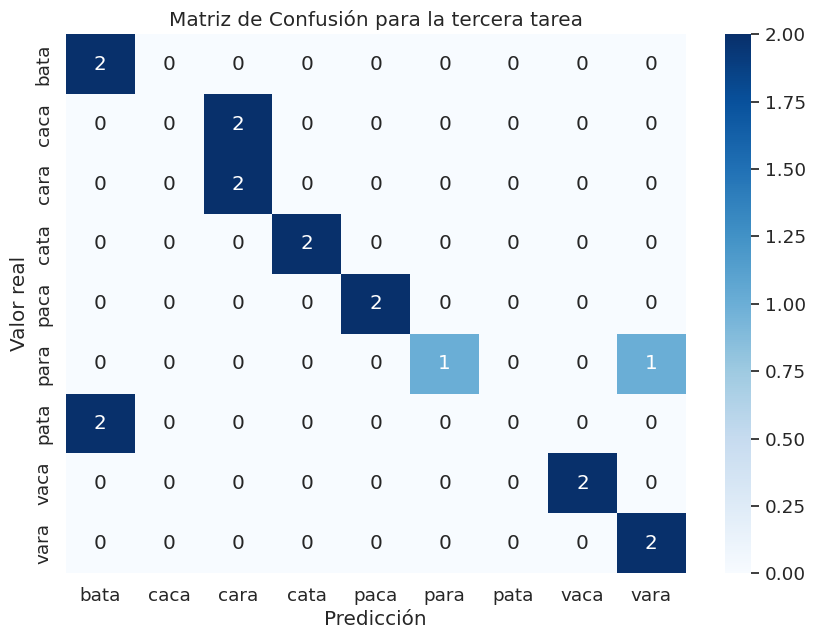

In [61]:
# Calculamos la matriz de confusión
conf_matrix = confusion_matrix(actual, predicted, labels=labels)

# Creamos la matriz de confusión
plt.figure(figsize=(10, 7))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicción')
plt.ylabel('Valor real')
plt.title('Matriz de Confusión para la quinta tarea')
plt.show()